# Investigating fluxes of stratification at the Weddell Sea mooring plume

Rowan Brown | 26.02.2025

This notebook is for exploring profiles at the Weddell Sea mooring (and in the MITgcm plume simulations) in terms of fluxes of stratifiation. In other words, it's for investigating 
 1. how to create initial conditions that reflect the stratification at the mooring in the Weddell Sea *combined* with 
 2. estimates of surface heat and salt fluxes, which *should* recreate the observed plume.

Our basic idea is to consider the starting stratification (i.e., profiles of heat and salt) from the mooring on (e.g.) September 14 (right before the plume) along with the ''end stratification'' on (e.g.,) September 16 (when the plume is in full-swing). By considering the difference in heat and salt content, we can flux the difference through the surface and see if the plume looks reasonably similar. 

In [1]:
# Imports
import numpy as np
import pandas as pd
import xmitgcm
import matplotlib.pylab as plt
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
import xmitgcm.file_utils
import xmitgcm.utils
from MITgcmutils import density
import xarray as xr
import gsw
import basic_model_anayses as bma
from datetime import datetime
import cell_thickness_calculator as ctc

import sys
sys.path.insert(1, '../obs_analyses/')
import mooring_analyses
import woa_analyses

## Prequel: Initial condition stability

Here, we're going to show salinity and temperature profiles, as used in the model, along with potential density or buoyancy frequency. The result will show how stable a certain combination of temperature and salinity initial conditions end up being. Note that salinities are absolute and temperatures are potential, since this is what *eosType=TEOS10* uses in MITgcm.

In [3]:
# Opening mds binaries 
ds = xmitgcm.open_mdsdataset('../MITgcm/so_plumes/mrb_048/', geometry='cartesian', prefix=['S','T'])
depths = ds['Z'].values

In [3]:
# Open the WOA data
with open('../filepaths/woa_filepath') as f: dirpath = f.readlines()[0][:-1] # the [0] accesses the first line, and the [:-1] removes the newline tag
das = xr.open_dataset(dirpath + '/WOA_monthly_'+'s'+'_'+str(2015)+'.nc',decode_times=False)['s_an']
s_woa = das.isel(time=8).interp(depth=(-1)*depths) # time=2 refers to "summer"
dat = xr.open_dataset(dirpath + '/WOA_monthly_'+'t'+'_'+str(2015)+'.nc',decode_times=False)['t_an']
t_woa = dat.isel(time=8).interp(depth=(-1)*depths) # time=2 refers to "summer"
p = gsw.p_from_z(depths,lat=-69.0005) # Calculating pressure from depth, then getting absolute salinity, and potential temperature 
SA = gsw.SA_from_SP(s_woa,p,lat=-69.0005,lon=-27.0048)           # ...(you should want theta/pt---this is what the model demands!)
pt = gsw.pt0_from_t(SA,t_woa,p)

Minimum N2 (should be positive!): -2.0098049411426554e-06


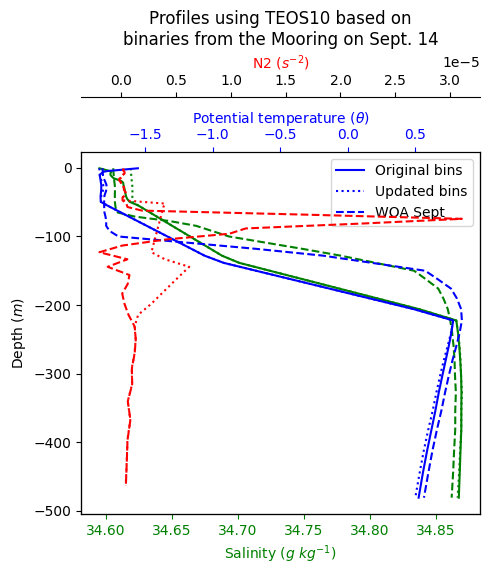

In [ ]:
# Opening init binaries 
open_bin = lambda f : xmitgcm.utils.read_raw_data('../MITgcm/so_plumes/binaries/'+f, shape=(50,150,150), dtype=np.dtype('>f4') )

# Binary names and plotting dictionaries
theta = "theta.mooringSept14.50x150x150.500m.bin"
theta2 = "theta.mooringSept14v2.50x150x150.500m.bin"
sa = "SA.mooringSept14.50x150x150.500m.bin"
sa2 = "SA.mooringSept14v2.50x150x150.500m.bin"

#== Plotting ==#
fig, ax = plt.subplots(figsize=(5,6))
ax.set_ylabel('Depth ($m$)')

# Salinity
ax.set_xlabel('Salinity ($g$ $kg^{-1}$)')
ax.plot(open_bin(sa)[:,75,75],depths,c='g',label='Original bins')
ax.plot(open_bin(sa2)[:,75,75],depths,c='g',ls=':',label='Updated bins')
ax.plot(SA,depths,c='g',ls='--',label='WOA Sept')
#ax.plot(ds['S'].isel(time=0,XC=75,YC=75).data,depths,c='g',ls=':',lw=3)
#ax.plot(ds['S'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(4*3600*1e9),'ns')).data,depths,c='g',ls='--',lw=3)
#ax.plot(ds['S'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(1*3600*1e9),'ns')).data,depths,c='g',ls='--',lw=1)
ax.xaxis.label.set_color('g')
ax.tick_params(axis='x', colors='g')

# Temperature
ax2 = ax.twiny()
ax2.set_xlabel(r'Potential temperature ($\theta$)')
ax2.plot(open_bin(theta)[:,75,75],depths,c='b',label='Original bins')
ax2.plot(open_bin(theta2)[:,75,75],depths,c='b',ls=':',label='Updated bins')
ax2.plot(pt,depths,c='b',ls='--',label='WOA Sept')
#ax2.plot(ds['T'].isel(time=0,XC=75,YC=75).data,depths,c='b',ls=':',lw=3)
#ax2.plot(ds['T'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(4*3600*1e9),'ns')).data,depths,c='b',ls='--',lw=3)
#ax2.plot(ds['T'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(1*3600*1e9),'ns')).data,depths,c='b',ls='--',lw=1)
ax2.xaxis.label.set_color('b')
ax2.tick_params(axis='x', colors='b')

plt.legend()

# Potential density OR N**2 (dealer's choice)
ax3 = ax.twiny()
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('N2 ($s^{-2}$)')#Potential density ($kg$ $m^{-3}$)')
#############################################
sa_profile = open_bin(sa)[:,75,75]
theta_profile = open_bin(theta)[:,75,75]
ct_profile = gsw.CT_from_pt(sa_profile,theta_profile)
N2, p_mid = gsw.Nsquared(sa_profile,ct_profile,gsw.p_from_z(depths,-69.0005),-69.0005)
ax3.plot(N2,gsw.z_from_p(p_mid,-69.0005),c='r',label='Original bins')
#############################################
sa_profile = open_bin(sa2)[:,75,75]
theta_profile = open_bin(theta2)[:,75,75]
ct_profile = gsw.CT_from_pt(sa_profile,theta_profile)
N2, p_mid = gsw.Nsquared(sa_profile,ct_profile,gsw.p_from_z(depths,-69.0005),-69.0005)
ax3.plot(N2,gsw.z_from_p(p_mid,-69.0005),c='r',ls=':',label='Updated bins')
#############################################
sa_profile = SA
theta_profile = pt
ct_profile = gsw.CT_from_pt(sa_profile,theta_profile)
N2, p_mid = gsw.Nsquared(sa_profile,ct_profile,gsw.p_from_z(depths,-69.0005),-69.0005)
ax3.plot(N2,gsw.z_from_p(p_mid,-69.0005),c='r',ls='--',label='WOA Sept')
#############################################

#sa_profile_model = ds['S'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(1*3600*1e9),'ns')).to_numpy()
#theta_profile_model = ds['T'].isel(XC=75,YC=75).sel(time=np.timedelta64(int(1*3600*1e9),'ns')).to_numpy()
#ct_profile_model = gsw.CT_from_pt(sa_profile_model,theta_profile_model)
#N2_model, p_mid_model = gsw.Nsquared(sa_profile_model,ct_profile_model,gsw.p_from_z(depths,-69.0005),-69.0005)
#ax3.plot(N2_model,gsw.z_from_p(p_mid_model,-69.0005),c='r',ls='--',lw=1)
#############################################
print("Minimum N2 (should be positive!): "+str(min(N2)))
ax3.xaxis.label.set_color('r')
ax3.tick_params(axis='x', colors='k')

plt.title('Profiles using TEOS10 based on\nbinaries from the Mooring on Sept. 14')
plt.tight_layout()

## Fluxes of stratification

From above, the stability of the initial conditions should be clear (I accidentally did a couple runs with a linear EOS and salt stepping turned off, which resulted in unstable initial conditions!). 

The next step is to roughly estimate how much heat and salt flux occured through the surface at the mooring. 

### A couple observations:
* For now, consider that sea water temperature cannot go below -1.8. If the temperature at 50 m is -1.8, in the autumn runs (N.H. autumn, so S.H. spring), then the whole surface above 50 m is likely also at -1.8. (Consider (a) that we're assuming a surface-driven plume; hence homogenised/cold/as-dense-as-can-be, and (b) the autumn WOA climatology is relatively homogenous; only the summer has a pronounced subsurface cold layer)
* Note to self: Revisit this! Salinity in the WOA climatologies *for all seasons* is fresher at the surface than at 50 m; in the autumn it is ~0.1 PSU less at the surface than at 25 m, with a very steep halocline. Another less steep halocline exists at 125 m. In a spring plume with breaking up sea ice, this is what we might expect. However, if the ice is breaking up due to wind coupled with intense *cooling*, i.e., a cold springtime storm, which explains the ostensibly heat-flux-driven plume, then perhaps there would be less melt, less of a freshwater cap, and maybe even continued brine rejection. I can think of no strong argument against this case, and hence I will assume that the salinity above 50 m is the same as at 50 m, just like with the temperature.

### Calculating heat content and flux
Heat content in a $1$ m $\times$ $1$ m column of water is calculated by integrating over depth, i.e., 
$$
    HC = \int \rho\ c_p\ T\ dz,
$$
where in this case $c_p$ is the isobaric heat capacity in $J\ kg^{-1}\ ℃^{-1}$ (calculated using gsw_cp_t_exact), $\rho$ is the in-situ (actually maybe it should be potential) density in $kg\ m^{-3}$, and $T$ is in-situ (I think but maybe could be potential if using potential density too?) temperature in $℃$. Integrating over depth (and the $1$ m $\times$ $1$ m column) gives units of $J$. We *could* using $T-T_{ref}$ but I don't see a good argument why, especially since we're only interested in the general rate of change of heat content. HF is HC derived over time, i.e., 
$$
    HF = \frac{d\ HC}{dt} 
$$

### Calculating salt content and flux
Similar calculations to heat flux, except the total salt content is found by simply multiplying the salinity by the density. In other words,
$$
    SC = \int \rho\ S\  dz \rightarrow SF = \frac{d\ SC}{dt},
$$
where the unit of salt content is *g* (consider, $\rho [kg/m^3]\ S[g/kg]$) and the unit of salt flux is *g* per day.

In [8]:
# First let's consider fluxes over time

# Opening the mooring data
time_delta='hour'
ds = mooring_analyses.open_mooring_ml_data(time_delta)
ds = mooring_analyses.correct_mooring_salinities(ds)
if time_delta=='hour': ds = ds.isel(day=slice(0,-1,2)) # In this case we need to alias the data

# Adding "cell" thicknesses associated with each of the 3 active sensors
dz = [(135-50)/2,np.nan,(135-50)/2+(220-135)/2,np.nan,(220-135)/2,np.nan]
ds = ds.assign_coords(dz=("depth",dz))

# Calculating the quantity of heat in the water column
ds['cp'] = gsw.cp_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # Isobaric cp; should potentially use 4000 (value from model)
ds['rho'] = gsw.rho_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # In-situ density (should potentially use potential?)
ds['HC'] = (ds['rho']*ds['cp']*ds['T']*ds['dz']).sum(dim='depth') # Unit: J
ds['HF'] = ds['HC'].diff('day')/7200 # Divide by 7200 because the dt of the output is 2 hours; unit: J/s (i.e., W) 

# Calculating the quantity of salt in the water column
ds['SC'] = (ds['SA']*ds['rho']*ds['dz']).sum(dim='depth') # Unit: g
ds['SF'] = ds['SC'].diff('day')/7200 # Divide by 7200 because the dt of the output is 2 hours; unit: g/day

print("You might want to test to make sure your calcs (like sum in depth and then differentiate) are working properly")

/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))


Mooring data opened
 50 m 12-month mean from mooring: 34.369026301369864
 50 m 12-month mean from WOA:     34.38139177087235
Difference: -0.012365469502483961

135 m 12-month mean from mooring: 34.62639991010118
135 m 12-month mean from WOA:     34.61529681898143
Difference: 0.011103091119750275

220 m 12-month mean from mooring: 34.65630465643637
220 m 12-month mean from WOA:     34.69025839191593
Difference: -0.03395373547956382
Salinities corrected
You might want to test to make sure your calcs (like sum in depth and then differentiate) are working properly


Average heat flux during Sept 14--16: -1604.2472533092364 W
Average salt flux during Sept 14--16: -0.029264986289034154 g/s
The minimum heat flux during the defined period is -0.6663608893861289
It occurs on 2021-09-14T14:00:00.000000000


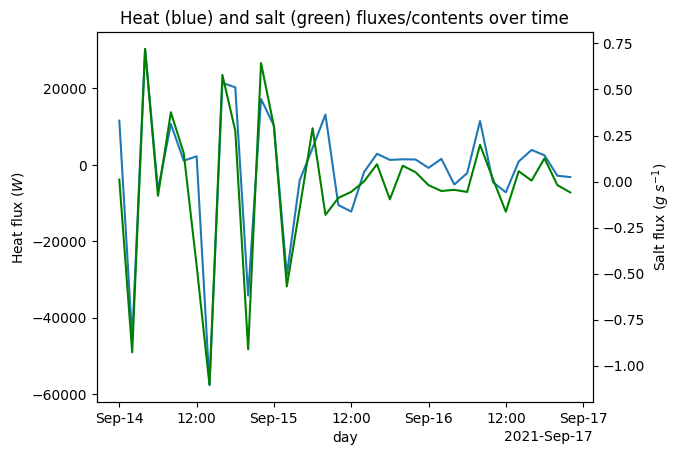

In [4]:
# Plotting timeseries of the fluxes
fig,ax = plt.subplots()
ds = ds.sel(day=slice("2021-09-14", "2021-09-16"))
#ds['HF2'] = ds['HF']/(24*60*60) # Divide by s per day to get W/m**2
#ds['HF2'].plot(ax=ax,label='Heat flux ($W$)')
ds['HF'].plot(ax=ax,label='Heat flux)')
ax2 = ax.twinx()
#ds['SF'].plot(ax=ax2,c='g',label='Salt flux ($g$ $s^{-1}$)')
ds['SF'].plot(ax=ax2,c='g',label='Salt flux')
plt.title('Heat (blue) and salt (green) fluxes/contents over time')
ax.set_ylabel('Heat flux ($W$)')
ax2.set_ylabel('Salt flux ($g$ $s^{-1}$)')
print("Average heat flux during Sept 14--16: " + str(ds['HF'].mean(dim='day').data) + ' W')
print("Average salt flux during Sept 14--16: " + str(ds['SF'].mean(dim='day').data) + ' g/s')
print("The minimum heat flux during the defined period is " + str(ds['HF'].min().data/(24*60*60))) # Unit: W
print("It occurs on " + str(ds['day'].isel(day=ds['HF'].argmin()).data))

### Now let's consider the net change in heat and salt over the two days

If we calculate the salt and heat difference between the start (pre-plume) and during (mid-plume) water columns, then we'll know exactly how much heat and salt to flux through the surface.

In [9]:
ds = mooring_analyses.open_mooring_ml_data(time_delta='hour')
ds = mooring_analyses.correct_mooring_salinities(ds)

# Adding cell thicknesses 
dz = [(135-50)/2,np.nan,(135-50)/2+(220-135)/2,np.nan,(220-135)/2,np.nan]
ds = ds.assign_coords(dz=("depth",dz))

# Add pt
ds = ds.assign(pt=gsw.pt0_from_t(ds['SA'],ds['T'],ds['p_from_z']))

start_ds = ds.sel(day=slice(datetime(2021,9,13,21),datetime(2021,9,14,3))).mean(dim='day')
end_ds = ds.sel(day=slice(datetime(2021,9,15,21),datetime(2021,9,16,3))).mean(dim='day') 

#start_ds = mooring_analyses.fill_mooring_with_WOA(ds.sel(day=slice(datetime(2021,9,13,21),datetime(2021,9,14,3))).mean(dim='day'))
#end_ds = mooring_analyses.fill_mooring_with_WOA(ds.sel(day=slice(datetime(2021,9,15,21),datetime(2021,9,16,3))).mean(dim='day'))

/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:84: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))


Mooring data opened
 50 m 12-month mean from mooring: 34.369026301369864
 50 m 12-month mean from WOA:     34.38139177087235
Difference: -0.012365469502483961

135 m 12-month mean from mooring: 34.62639991010118
135 m 12-month mean from WOA:     34.61529681898143
Difference: 0.011103091119750275

220 m 12-month mean from mooring: 34.65630465643637
220 m 12-month mean from WOA:     34.69025839191593
Difference: -0.03395373547956382
Salinities corrected


In [5]:
display(start_ds)

<xarray.Dataset> Size: 336B
Dimensions:   (depth: 6)
Coordinates:
  * depth     (depth) int64 48B -50 -90 -135 -170 -220 -250
    p_from_z  (depth) float64 48B 50.51 90.94 136.4 171.8 222.4 252.7
Data variables:
    T         (depth) float64 48B -1.828 -1.824 -1.002 0.6803 0.8308 0.8261
    S         (depth) float64 48B 34.45 nan 34.53 nan 34.69 nan
    P         (depth) float64 48B 49.64 nan 125.4 nan nan nan
    SA        (depth) float64 48B 34.62 nan 34.69 nan 34.87 nan
    pot_rho   (depth) float64 48B 27.74 nan 27.77 nan 27.82 nan

In [10]:
# Heat content
def HC(ds):
    cp = 4000 # This is the value used in the model, so it's what we'll use here
    pot_rho = gsw.sigma0(ds['SA'],gsw.CT_from_pt(ds['SA'],ds['pt'])) # Note for rho we're going to use 
    return (pot_rho*cp*ds['pt']*ds['dz']).sum(dim='depth') # Unit: J

print("The heat content at the start is: " + str(HC(start_ds).data/1e6) + ' MJ')
print("The heat content at the end is:   " + str(HC(end_ds).data/1e6) + ' MJ')
print("This represents a loss of " + str( (HC(end_ds).data-HC(start_ds).data)/(48*60*60) ) + " W/m**2 for 48 hours" )
print("Now the question becomes 'How much heat was lost through the surface'?")
print("(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)")
print("")

# Salt content
def SC(ds):
    pot_rho = gsw.sigma0(ds['SA'],gsw.CT_from_pt(ds['SA'],ds['pt'])) # Note for rho we're going to use 
    return (pot_rho*ds['SA']*ds['dz']).sum(dim='depth') # Unit: g

print("The salt content at the start is: " + str(SC(start_ds).data/1e3) + ' kg')
print("The salt content at the end is:   " + str(SC(end_ds).data/1e3) + ' kg')
print("This represents a loss of " + str( (SC(end_ds).data-SC(start_ds).data)/(48*60*60) ) + " g/m**2 for 48 hours" )
print("As with heat, now the question becomes 'How much salt was fluxed through the surface'?")
#print("(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)")
print("")


The  at the start is: -14.236002968984566 MJ
The heat content at the end is:   -21.026282594060685 MJ
This represents a loss of -39.295599682153465 W/m**2 for 48 hours
Now the question becomes 'How much heat was lost through the surface'?
(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)

The salt content at the start is: 163.95268849855964 kg
The salt content at the end is:   163.81173307872547 kg
This represents a loss of -0.0008157142351515007 g/m**2 for 48 hours
As with heat, now the question becomes 'How much salt was fluxed through the surface'?



## What about in the model?

Now let's consider the same things in the model. They should become closer with iterations of changin surface heat flux. 

In [8]:
# Open the model data
#run = '../../../work/projects/p_so-clim/GCM_data/RowanMITgcm/mrb_040/'
run = '../MITgcm/so_plumes/mrb_049/'
ds_model = bma.open_mitgcm_output_all_vars(run)

In [12]:
# Extracting the start and end profiles
ds = bma.calculate_sigma0_TEOS10(ds_model.isel(XC=75,YC=75,XG=75,YG=75,drop=False))
start_hour, end_hour = 1, 71
ds_start = ds.sel(Z=slice(-49.5,-222.5)).sel(time=np.timedelta64(int(start_hour*3600*1e9),'ns'))
ds_end = ds.sel(Z=slice(-49.5,-222.5)).sel(time=np.timedelta64(int(end_hour*3600*1e9),'ns'))

You need to test if you can use gsw in this way, feeding it ds and da etc


In [13]:
# Heat content
def HC(ds):
    cp = 4000 # This is the value used in the model, so it's what we'll use here
    return (ds['rho_theta']*cp*ds['T']*ds['drF']).sum(dim='Z') # Unit: J # CHECK IF THIS IS DRF OR DRC WHEN BACK AT WORK!!

print("The heat content at the start is: " + str(HC(ds.isel(time=0)).to_numpy()/1e6) + ' MJ')
print("The heat content at the end is:   " + str(HC(ds.isel(time=-1)).to_numpy()/1e6) + ' MJ')
print("This represents a loss of " + str( (HC(ds.isel(time=-1)).to_numpy()-HC(ds.isel(time=0)).to_numpy())/(48*60*60) ) + " W/m**2 for 48 hours" )
print("Now the question becomes 'How much heat was lost through the surface'?")
print("(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)")
print("")

# Salt content
def SC(ds):
    #pot_rho = gsw.sigma0(ds['S'],gsw.CT_from_pt(ds['S'],ds['T'])) # Note for rho we're going to use 
    return (ds['rho_theta']*ds['S']*ds['drF']).sum(dim='Z') # Unit: g

print("The salt content at the start is: " + str(SC(ds.isel(time=0)).to_numpy()/1e3) + ' kg')
print("The salt content at the end is:   " + str(SC(ds.isel(time=-1)).to_numpy()/1e3) + ' kg')
print("This represents a loss of " + str( (SC(ds.isel(time=-1)).to_numpy()-SC(ds.isel(time=0)).to_numpy())/(48*60*60) ) + " g/m**2 for 48 hours" )
print("As with heat, now the question becomes 'How much salt was fluxed through the surface'?")
#print("(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)")
print("You need to look at the salt content only beween 50 and 220 m, since what's happened post-convection at the surface surely isn't in WOA")


The heat content at the start is: -4.883919144665863 MJ
The heat content at the end is:   -1.9250683076266353 MJ
This represents a loss of 17.12297938101405 W/m**2 for 48 hours
Now the question becomes 'How much heat was lost through the surface'?
(Likely more than 65 W/m**2 since there would be a resultant upwards flux of heat too)

The salt content at the start is: 483.72521939283934 kg
The salt content at the end is:   484.0716473222141 kg
This represents a loss of 0.002004791257955663 g/m**2 for 48 hours
As with heat, now the question becomes 'How much salt was fluxed through the surface'?
You need to look at the salt content only beween 50 and 220 m, since what's happened post-convection at the surface surely isn't in WOA


Below is a work-in-progress...

In [13]:
# Open the model data
run = '../../../work/projects/p_so-clim/GCM_data/RowanMITgcm/mrb_034/'
ds_model = bma.open_mitgcm_output_all_vars(run)

# Adding density and pressure as variables
ds_model = bma.calculate_sigma0_TEOS10(ds_model)
ds_model = bma.calculate_pressure(ds_model,g=9.81)

# Taking only the cell/water column that we want (the middle one), the variables we want, and the depth range we want
ds = ds_model.isel(XC=75,YC=75,XG=75,YG=75,drop=False)
ds = ds.where( (ds['Z']<-50) & (ds['Z']>-220),drop=True)
ds = ds.drop_vars(['W','Eta','V','PH','PHL']) 

KeyboardInterrupt: 

In [ ]:
# Calculations
ds = ds.resample(time='2h').mean() # Means like the mooring data
ds['cp'] = gsw.cp_t_exact(ds['S'],ds['T'],gsw.p_from_z(ds['Z'],lat=-69.0005))
ds['HC'] = (ds['rho_theta']*ds['cp']*ds['T']*ds['drF']).sum(dim='Z')    # Unit: J
ds['HF'] = ds['HC'].diff('time')/7200   # Output is every 180 seconds    # Unit: J/s (i.e., W)
ds['SC'] = (ds['S']*ds['rho_theta']*ds['drF']).sum(dim='Z')            # Unit: g
ds['SF'] = ds['SC'].diff('time')/7200                                    # Unit: g/s

In [ ]:
# Fixing the time coord... 
start_time = np.datetime64("2021-09-14")
ds['time'] = [ start_time + t*3 for t in ds['time'].to_numpy() ] # *3 because the output timestamps are off by 1/3 (neet to fix this)

Text(0, 0.5, 'Salt flux')

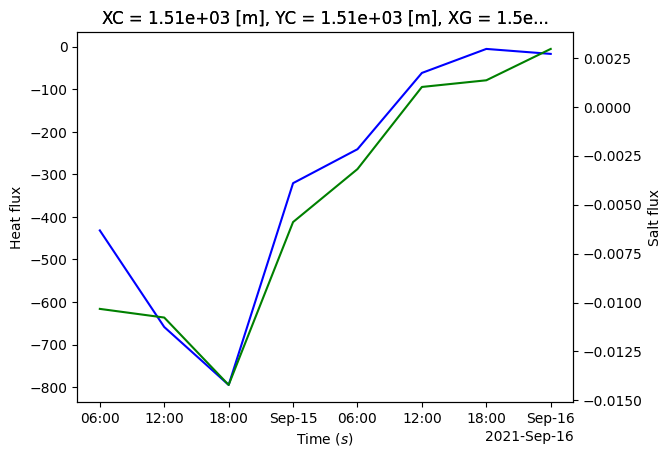

In [ ]:
# Plotting
fig, ax = plt.subplots()
ax.set_title('Model contents')

ds['HF'].plot(ax=ax, label='Model heat flux', c='b')
ax.set_xlabel('Time ($s$)')
ax.set_ylabel('Heat flux')

ax2 = ax.twinx()
ds['SF'].plot(ax=ax2, label='Model salt flux', c='g')
ax2.set_ylabel('Salt flux')

## Conclusion

I believe salt content / brine rejection come into play by densifying the surface throughout the winter and eroding stratification. Then a pulse of heat loss causes rapid sinking. Immediately afterwards, there is a negative flux of salt associated with fresh and cold surface water moving down; we don't see warm/salty CDW coming up in this dataset due to the location and vertical/time fidelity, but we probably will see it in the vicinity of the plume in the model. Hence I will force the model with the surface heat flux (roughly based on the values from here) but NOT surface salt flux; the inner-plume salinity is dominated by sea water dynamics, not some kind of rapid ice pulse (again: ice processes come into play by affecting the pre-stratification so that a plume can be triggered by HF). Also note that the surface heat flux in the spring "storm" (or whatever caused it) is likely much stronger than shown here since this integrated calculation likely accounts for some warm water coming up over the course of the day. 

## Bonus: What is the stratification like immediately before the plume?

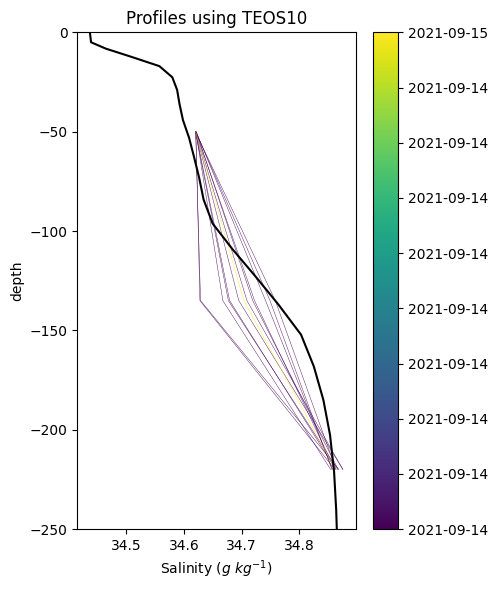

In [29]:
from datetime import datetime, timedelta # For handling dates and times

# Init the figure
fig, ax = plt.subplots(figsize=(5,6))
ax.set_ylabel('Depth ($m$)')

# Slice the mooring data that we want
ds = ds.sel(day=slice('2021-09-01T00:00:00.000000000','2021-09-15T00:00:00.000000000'))

# Get dates
dates = [pd.Timestamp(day) for day in ds['day'].values]

# Plot mooring data in a loop
norm = plt.Normalize(dates[0].toordinal(), dates[-1].toordinal()) # This is for hanlding the colouring of the lines 
cmap = plt.cm.viridis # "viridis" is a nice colourmap that isn't, usually, a problem for people with colourblindness
for n, date in enumerate(dates): # Looping through each date...
    c = cmap(norm(date.toordinal())) # Obtaining the colour 
    ds['SA'].isel(day=n).dropna('depth').plot(y='depth',ax=ax, color=c, lw=0.3)

# The following is almost directly from Copilot, and it handles the colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
cbar = plt.colorbar(sm, ax=ax)
tick_locs = np.linspace(dates[0].toordinal(), dates[-1].toordinal(), len(dates[:10:]))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([pd.Timestamp.fromordinal(int(tick)).strftime('%Y-%m-%d') for tick in tick_locs])

# Comparing to the WOA-based binaries that I've been initialising with
open_bin = lambda f : xmitgcm.utils.read_raw_data('../MITgcm/so_plumes/binaries/'+f, shape=(50,100,100), dtype=np.dtype('>f4') )
depths = xmitgcm.open_mdsdataset('../MITgcm/so_plumes/mrb_028/',geometry='cartesian',prefix=['S','T'],iters=[0])['Z'].values
ax.plot(open_bin('SA.WOA2015.50x100x100.autumn.bin')[:,50,50],depths,c='k')

ax.set_ylim(-250,0)
ax.set_xlabel('Salinity ($g$ $kg^{-1}$)')
plt.title('Profiles using TEOS10')
plt.tight_layout()